# Practical Two: Image Resizing, Filtering, and Convolutions

This notebook is prepared to introduce you to the basics of image resizing, filtering, and convolutions in Python.

### References
* [Based on "Homework 1: Resizing and Filtering"](https://github.com/pjreddie/vision-hw1)
* [Lecture 04 - Resizing, Filtering, and Convolutions](https://docs.google.com/presentation/d/1c4Jg3txwrayxk4obdMqs1hfT4iNlo-u1O8y1pLeWgFw/edit?usp=sharing)

## Load Required Modules

In [33]:
from PIL import Image
from IPython.display import display
import numpy as np

- `Python version: 3.9.7`
- `Pillow version: 9.4.0`
- `numpy version: 1.21.5`

In [34]:
def np2img(im, norm=False, rgb_mode=False):
    """
    This function converts the input numpy object im to Image object and returns
    the converted object. If norm == True, then the input is normalised to [0,1]
    using im <- (im - im.min()) / (im.max() - im.min()).
    """
    if norm:
        if ((im.max() - im.min()) != 0.0):
            im = (im - im.min()) / (im.max() - im.min())

    if ((im.min() >= 0.0) and (im.max() <= 1.0)):
        im = im * 255.0

    if rgb_mode and im.ndim == 2:
        im = im[...,np.newaxis].repeat(3, axis=2)
        
    if im.ndim == 2:
        im = Image.fromarray(im.astype(np.uint8), mode='L')
    elif (im.ndim == 3) and (im.shape[2] == 3):
        im = Image.fromarray(im.astype(np.uint8), mode='RGB')

    return im

## 1. Image Resizing

We've been talking a lot about resizing and interpolation in class. Now's your time to do it! To resize an image, we'll need some interpolation methods and a function to create a new image and fill it in with our interpolation methods:
* `imresize_nn(im, width, height)` resizes the input Image object im to the size of (width x height) pixels based on the nearest neigbor interpolation and returns the resized image as an Image object. This function is implemented for you.
* `imresize_bi(im, width, height)` resizes the input Image object im to the size of (width x height) pixels based on the bilinear interpolation and returns the resized image as an Image object.

In [35]:
def imresize_nn(im, width, height, img_obj=True):
    """
    This function resizes the input Image object im to the size of (width x height)
    pixels based on the nearest neigbor interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object
    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1] - 0.5) - (-0.5)) / ((im_res.shape[1] - 0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        a_y = ((im.shape[0] - 0.5) - (-0.5)) / ((im_res.shape[0] - 0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)

        # Create a lookup table for speeding up the operations
        y_im = np.zeros(im_res.shape[0], dtype=np.int32)
        for i in range(im_res.shape[0]):
            y_im[i] = int(np.round(a_y * i + b_y))
            if y_im[i] < 0:
                y_im[i] = 0
            if y_im[i] > (im.shape[0] - 1):
                y_im[i] = im.shape[0] - 1

        x_im = np.zeros(im_res.shape[1], dtype=np.int32)
        for i in range(im_res.shape[1]):
            x_im[i] = int(np.round(a_x * i + b_x))
            if x_im[i] < 0:
                x_im[i] = 0
            if x_im[i] > (im.shape[1] - 1):
                x_im[i] = im.shape[1] - 1
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                im_res[y, x] = im[y_im[y], x_im[x]]

    if img_obj:
        im_res = np2img(im_res)

    return im_res

Now you should be able to run the following Python code snippet.

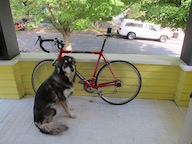

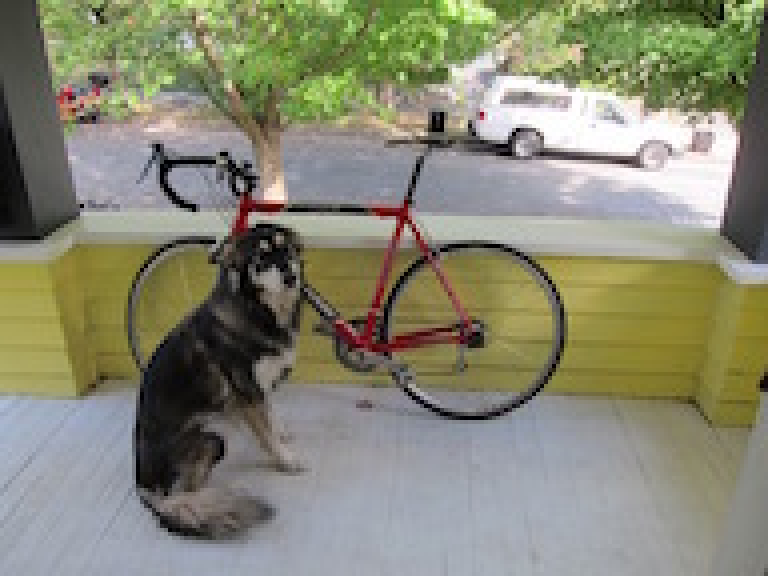

In [36]:
im = Image.open('../data/dogsmall.jpg')
width, height = int(im.width*4), int(im.height*4)
im_res = imresize_nn(im, width, height)
display(im)
display(im_res)

If your implementation is correct, then you should expect to produce the following test results.

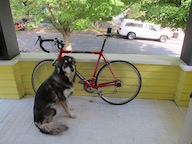

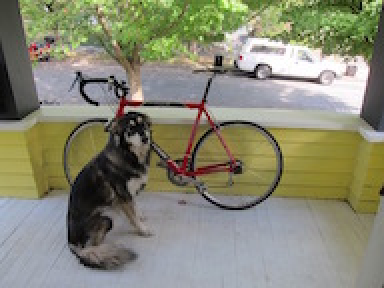

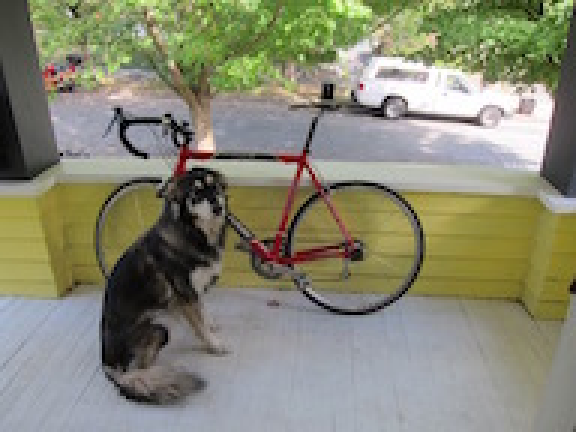

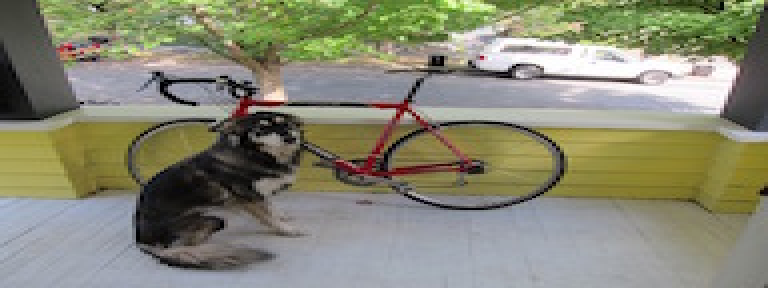

In [37]:
im = Image.open('../data/dogsmall.jpg')

width, height = int(im.width*1), int(im.height*1)
test0 = imresize_nn(im, width, height)

width, height = int(im.width*2), int(im.height*2)
test1 = imresize_nn(im, width, height)

width, height = int(im.width*3), int(im.height*3)
test2 = imresize_nn(im, width, height)

width, height = int(im.width*4), int(im.height*2)
test3 = imresize_nn(im, width, height)

display(test0)
display(test1)
display(test2)
display(test3)

### Your Task {35 Marks}

Now you need complete the implementation of the following function `imresize_bi(im, width, height)` to resize the input Image object im to the size of (width x height) pixels based on the bilinear interpolation. Note that, you also need to correct some of the bugs in this function.

In [38]:
def imresize_bi(im, width, height, img_obj=True):
    """
    This function resizes the input Image object im to the size of (width x height) 
    pixels based on the bilinear interpolation and returns the resized Image object.
    """
    # Convert the input Image object to numpy array object

    im = np.array(im).astype(float)
    if (im.shape[0] == height) and (im.shape[1] == width):
        im_res = im.copy()
    else:
        # Create an empty array of (height x width) pixels
        if im.ndim == 2:
            im_res = np.zeros((height, width))
        else:
            im_res = np.zeros((height, width, im.shape[2]))

        # Match up coordinates using (x_res, y_res) -> (x_im, y_im), i.e.,
        # a_x * x_res + b_x = x_im
        # a_y * y_res + b_y = y_im
        a_x = ((im.shape[1]-0.5) - (-0.5)) / ((im_res.shape[1]-0.5) - (-0.5))
        b_x = (-0.5) - a_x * (-0.5)
        
        a_y = ((im.shape[0]-0.5) - (-0.5)) / ((im_res.shape[0]-0.5) - (-0.5))
        b_y = (-0.5) - a_y * (-0.5)
        
        # Create a lookup table for speeding up the operations
        y_im = np.zeros((im_res.shape[0], 2), dtype=np.int32)
        y_im_d = np.zeros((im_res.shape[0], 2), dtype=np.float32)

        #print(y_im)
        #print(y_im_d)

        for i in range(im_res.shape[0]):
            y_im_ = a_y * i + b_y
            # Take care of the boundary cases
            if y_im_ < 0.0:
                y_im_ = np.abs(y_im_)
            if y_im_ > (im.shape[0]-1):
                y_im_ = (im.shape[0]-1) - (y_im_-(im.shape[0]-1))
            # Compute the mapping in the input image coordinate
            y_im[i,0] = int(np.floor(y_im_))
            y_im[i,1] = int(np.ceil(y_im_))
            y_im_d[i,0] = y_im[i,1] - y_im_
            y_im_d[i,1] = y_im_ - y_im[i,0]
            

        x_im = np.zeros((im_res.shape[1], 2), dtype=np.int32)
        x_im_d = np.zeros((im_res.shape[1], 2), dtype=np.float32)
        for i in range(im_res.shape[1]):
            x_im_ = a_x * i + b_x
            # Take care of the boundary cases
            if x_im_ < 0.0:
                x_im_ = np.abs(x_im_)
            if x_im_ > (im.shape[1]-1):
                x_im_ = (im.shape[1]-1) - (x_im_-(im.shape[1]-1))
            # Compute the mapping in the input image coordinate
            x_im[i,0] = int(np.floor(x_im_))
            x_im[i,1] = int(np.ceil(x_im_))
            x_im_d[i,0] = x_im[i,1] - x_im_
            x_im_d[i,1] = x_im_ - x_im[i,0]
        
        # Iterate over new points
        for y in range(im_res.shape[0]):
            for x in range(im_res.shape[1]):
                if (x_im[x,0] == x_im[x,1]) and (y_im[y,0] == y_im[y,1]):
                    q = im[y_im[y,0], x_im[x,0]]
                elif (x_im[x,0] == x_im[x,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v3 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * y_im_d[y,0] + v3 * y_im_d[y,1]
                elif (y_im[y,0] == y_im[y,1]):
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,1], x_im[x,1]]
                    q = v1 * x_im_d[x,0] + v2 * x_im_d[x,1]
                else:
                    # buge here i think
                    #q = im[y_im[y,0], x_im[x,0]]
                    v1 = im[y_im[y,0], x_im[x,0]]
                    v2 = im[y_im[y,0], x_im[x,1]]
                    v3 = im[y_im[y,1], x_im[x,0]]
                    v4 = im[y_im[y,1], x_im[x,1]]
                    #d1 = x_im_d[x,0]
                    #d2 = x_im_d[x,1]
                    #d3 = y_im_d[y,0]
                    #d4 = y_im_d[y,1]
                    d1 = y_im_d[y,0]
                    d2 = y_im_d[y,1]
                    d3 = x_im_d[x,0]
                    d4 = x_im_d[x,1]
                    q1 = v1*d2 + v2*d1
                    q2 = v3*d2 + v4*d1
                    q = q1*d4 + q2*d3

                    #q = v1*a1 + v2*a2 + v3*a3 + v4*a4
    
                im_res[y, x] = q

    if img_obj:
        im_res = np2img(im_res)
    
    return im_res

If your implementation of `imresize_bi(im, width, height)` is correct, then you can expect to produce the following outputs.

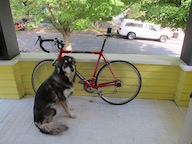

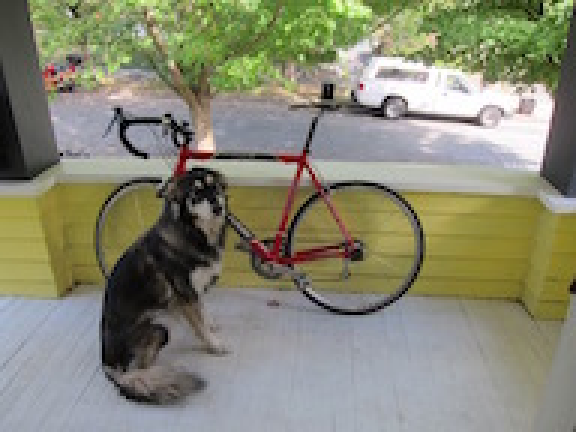

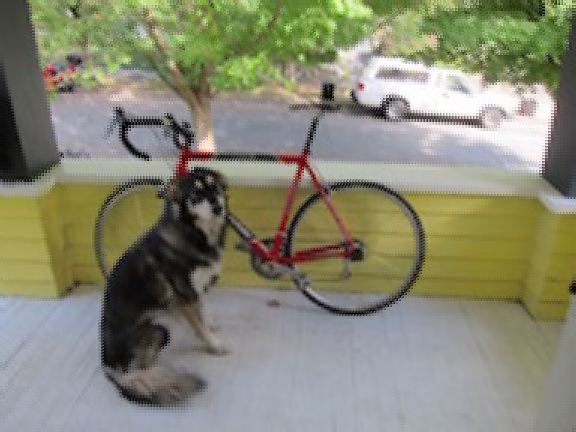

In [39]:
im = Image.open('../data/dogsmall.jpg')
width, height = int(im.width*3), int(im.height*3)
display(im)
display(imresize_nn(im, width, height))
display(imresize_bi(im, width, height))

If your implementation of `imresize_bi(im, width, height)` is correct, then you should expect to produce the following test results.

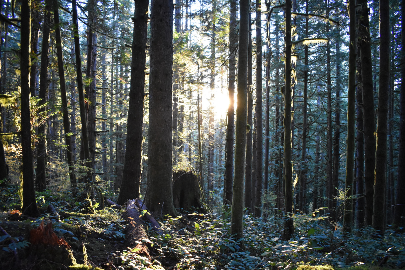

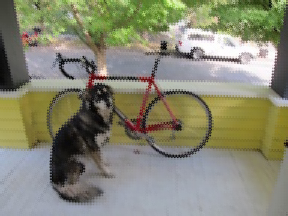

In [40]:
im = Image.open('../data/forest.jpg')
width, height = int(im.width*0.25), int(im.height*0.25)
test1 = imresize_bi(im, width, height)

im = Image.open('../data/dogsmall.jpg')
width, height = int(im.width*1.5), int(im.height*1.5)
test2 = imresize_bi(im, width, height)

display(test1)
display(test2)

## 2. Image Filtering with Convolutions

We talked about image filtering using convolution ($*$) in the previous class. In this section, we will implement image filtering on 2D images. For a color image, you will need to apply filtering on each color channel.

### 2.1 Box Filter

You will recall that a $h \times w$ box filter is nothing but a $h \times w$ ($h$ rows and $w$ columns) array with all entries equal to $\frac{1}{h \times w}$. The $5 \times 3$ box filter look like this:

$
 \begin{array}{|c|c|c|} \hline \frac{1}{5 \times 3} & \frac{1}{5 \times 3} & \frac{1}{5 \times 3} \\ \hline \frac{1}{5 \times 3} & \frac{1}{5 \times 3} & \frac{1}{5 \times 3} \\ \hline \frac{1}{5 \times 3} & \frac{1}{5 \times 3} & \frac{1}{5 \times 3} \\ \hline \frac{1}{5 \times 3} & \frac{1}{5 \times 3} & \frac{1}{5 \times 3} \\ \hline \frac{1}{5 \times 3} & \frac{1}{5 \times 3} & \frac{1}{5 \times 3} \\ \hline \end{array}.
$

Similarly, the $3 \times 3$ box filter look like this:

$
 \begin{array}{|c|c|c|} \hline \frac{1}{3 \times 3} & \frac{1}{3 \times 3} & \frac{1}{3 \times 3} \\ \hline \frac{1}{3 \times 3} & \frac{1}{3 \times 3} & \frac{1}{3 \times 3} \\ \hline \frac{1}{3 \times 3} & \frac{1}{3 \times 3} & \frac{1}{3 \times 3} \\ \hline \end{array}.
$

One way to create a $h \times w$ box filter is to create a $h \times w$ numpy array, fill it in with all 1s, and then normalize it. Without loosing generality, we will assume that $h$ and $w$ are odd natural numbers. The following function `box_filter(width, height, channel)` can be used to create and return a box filter of $height \times width$:

In [41]:
def box_filter(width, height, channel=1):
    """
    This function creates and returns a numpy array of size (height x width) with all entries equal to 1/(height x width x channel). 
    If any of input parameters width and height is an even number, then it is rolled up to the nearest
    odd number. Note that if channel > 1, then the returned array will be of dimensions (height x width x channel).
    """
    if (width % 2) == 0:
        width += 1
    if (height % 2) == 0:
        height += 1

    if channel > 1:
        data = np.ones((height, width, channel)) / (height * width * channel)
    else:
        data = np.ones((height, width)) / (height * width)

    # Create a width x height numpy array for the filter
    # The bug with this code to make sure it keeps its dimensions
    #box = np.ones((height, width))



    return data

Here is the expected output for `display(box_filter(5, 5))`

       array([[0.04, 0.04, 0.04, 0.04, 0.04],
              [0.04, 0.04, 0.04, 0.04, 0.04],
              [0.04, 0.04, 0.04, 0.04, 0.04],
              [0.04, 0.04, 0.04, 0.04, 0.04],
              [0.04, 0.04, 0.04, 0.04, 0.04]])

and the expected output for `display(box_filter(2, 3, 3))` is

       array([[[0.03703704, 0.03703704, 0.03703704],
              [0.03703704, 0.03703704, 0.03703704],
              [0.03703704, 0.03703704, 0.03703704]],

              [[0.03703704, 0.03703704, 0.03703704],
              [0.03703704, 0.03703704, 0.03703704],
              [0.03703704, 0.03703704, 0.03703704]],

              [[0.03703704, 0.03703704, 0.03703704],
              [0.03703704, 0.03703704, 0.03703704],
              [0.03703704, 0.03703704, 0.03703704]]])

### Your Task {20 Marks}

The implementation of `box_filter(width, height, channel)` either has a bug or is incomplete. If your implementation of `box_filter(width, height, channel)` is correct, then you should expect to produce the following test results.

In [42]:
width, height = 5, 5
test0 = box_filter(width, height)

width, height = 7, 5
test1 = box_filter(width, height)

width, height = 2, 2
test2 = box_filter(width, height)

width, height, channel = 2, 3, 3
test3 = box_filter(width, height, channel)

display(test0)
display(test1)
display(test2)
display(test3)

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

array([[0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143],
       [0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143],
       [0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143],
       [0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143],
       [0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143]])

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

array([[[0.03703704, 0.03703704, 0.03703704],
        [0.03703704, 0.03703704, 0.03703704],
        [0.03703704, 0.03703704, 0.03703704]],

       [[0.03703704, 0.03703704, 0.03703704],
        [0.03703704, 0.03703704, 0.03703704],
        [0.03703704, 0.03703704, 0.03703704]],

       [[0.03703704, 0.03703704, 0.03703704],
        [0.03703704, 0.03703704, 0.03703704],
        [0.03703704, 0.03703704, 0.03703704]]])

### 2.2 Convolution Function

Now it's time to fill in `imconv(im, filter, preserve)`. For this function we have a few scenarios. With normal convolutions we do a weighted sum over an area of the image. With multiple channels in the input image there are a few possible cases we want to handle:

- If `filter` and `im` have the same number of channels then it's just a normal convolution. We sum over spatial and channel dimensions and produce a 1 channel image. UNLESS:
- If `preserve` is set to `True` we should produce an image with the same number of channels as the input. This is useful if, for example, we want to run a box filter over an RGB image and get out an RGB image. This means each channel in the image will be filtered by the corresponding channel in the filter. UNLESS:
- If the `filter` only has one channel but `im` has multiple channels we want to apply the filter to each of those channels. Then we either sum between channels or not depending on if `preserve` is set.

Also, `filter` better have either the same number of channels as `im` or have 1 channel.

We are calling this a convolution but you don't need to flip the filter or anything (we're actually doing a cross-correlation). Just apply it to the image as we discussed in class.



In [43]:
 def imconv(im, filter, preserve=False, img_obj=True, mode='edge'):
    """
    This function filters the input object im with the numpy array filter and 
    returns the filtered image object.
    """
    # Convert the input object to numpy array object
    im = np.array(im).astype(float)
    if (im.ndim == 2):
        im = im[...,np.newaxis]
    # Get the filter dimensions
    h, w = filter.shape[:2][0] // 2, filter.shape[:2][1] // 2
    if (filter.ndim == 2):
        filter = filter[...,np.newaxis]
    # Apply padding on the input image to handle image boundaries
    pad_width = [[h,h],[w,w]]
    for d in range(2, im.ndim):
        pad_width.append([0,0])
    im = np.pad(im, pad_width=pad_width, mode=mode)
    # Create placeholder for the filtered image
    if preserve:    # bug here
        im_ = im.copy()
        # print(im_.shape)
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                # bug this line? does not work on 3d, only 2d. fix

                local_region = im[y-h:y+h+1, x-w:x+w+1, :]
                # Axis means that the x and y axis will be summed together for each of the three layers
                # ex x and y in dimension 1, x and y in dimension 2, and x and y in dimension 3.
                output_pixel = np.sum(local_region * filter, axis=(0,1))
                im_[y,x,:] = output_pixel

                    #im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum()
                #im_[y, x, :] = (im[y-h:y+h+1, x-w:x+w+1, :] * filter).sum()
    else:
        im_ = np.zeros(im.shape[:2])
        # Iterate over pixels
        for y in range(h, im.shape[0]-h):
            for x in range(w, im.shape[1]-w):
                    im_[y,x] = (im[y-h:y+h+1, x-w:x+w+1] * filter).sum()

    # Exclude the boundary pixels
    im = im_[h:im.shape[0]-h, w:im.shape[1]-w]

    if img_obj:
        im = np2img(im)
    
    return im

If your implementation of `convim(im, filter, preserve)` is correct, then you can expect to produce the following outputs.

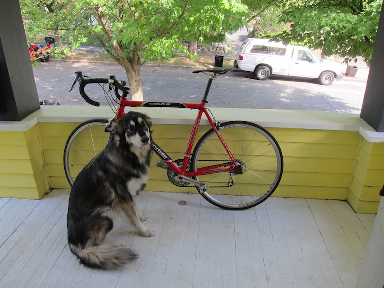

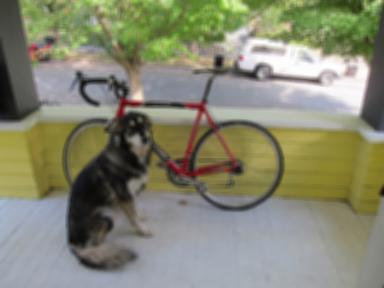

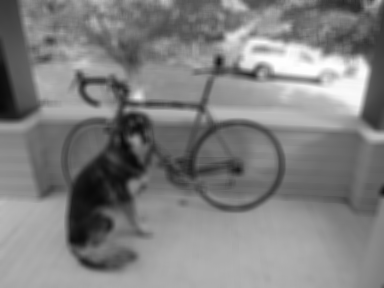

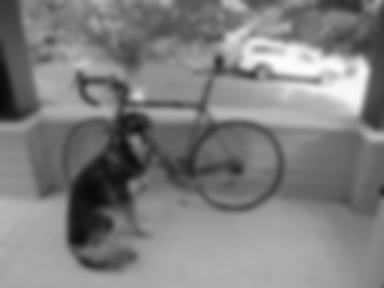

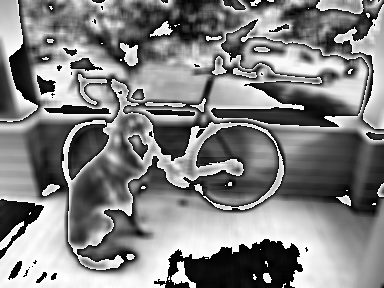

In [44]:
im = Image.open('../data/dog.jpg')
im = imresize_nn(im, int(im.width * 0.5), int(im.height * 0.5))
display(im)

filter = box_filter(5, 5)
im_filt = imconv(im, filter, preserve=1)
display(im_filt)

filter = box_filter(7, 7, 3)
im_filt = imconv(im, filter, preserve=0)
display(im_filt)

filter = box_filter(7, 7)
im_filt = imconv(im_filt, filter, preserve=0)
display(im_filt)

filter = box_filter(7, 7)
im_filt = imconv(im, filter, preserve=0)
display(im_filt)

### Your Task {35 Marks}

The implementation of `convim(im, filter, preserve)` either has bug in it or is incomplete. If your implementation of `box_filter(width, height, channel)` is correct, then you should expect to produce the following test results.

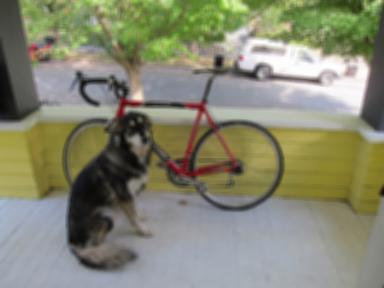

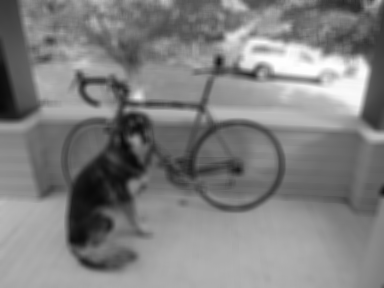

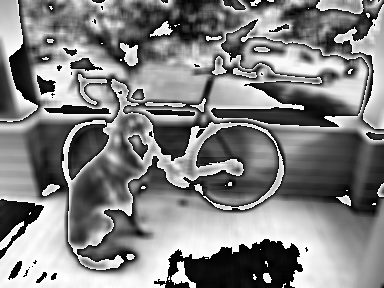

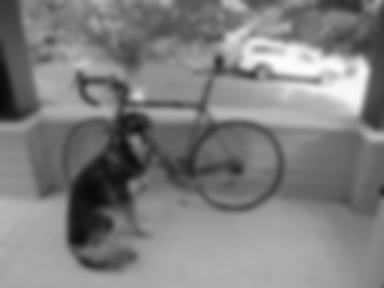

In [45]:
im = Image.open('../data/dog.jpg')
im = imresize_nn(im, int(im.width * 0.5), int(im.height * 0.5))

filter = box_filter(5, 5)
test0 = imconv(im, filter, preserve=1)

filter = box_filter(7, 7, 3)
test1 = imconv(im, filter, preserve=0)

filter = box_filter(7, 7)
test2 = imconv(im, filter, preserve=0)

filter = box_filter(7, 7)
test3 = imconv(test1, filter)

display(test0)
display(test1)
display(test2)
display(test3)

### 2.3 Cool Filters :)

As we discussed in the class, we can use some special filters to apply special effects on the images. The following function `cool_filter(type)` can be used to create and return a cool $3 \times 3$ cool filter. We are particularly interested in the following cool filters: $3 \times 3$ Highpass, $3 \times 3$ Sharpen, and $3 \times 3$ Emboss.

In [46]:
def cool_filter(type):  # fix this function
    """
    Returns a 3x3 cool filter as a numpy array.
    """
    filter = box_filter(3,3)

    if type == 'highpass':
        filter = np.array([[ 0, -1,  0], [-1,  4, -1], [ 0, -1,  0]])
    elif type == 'sharpen':
        filter = np.array([[ 0, -1,  0], [-1,  5, -1], [ 0, -1,  0]])
    elif type == 'emboss':
        filter = np.array([[-2, -1,  0], [-1,  1,  0], [ 0,  1,  2]])
    else:
        print('Invalid "type"')
        
    return filter

Complete the function `cool_filter(type)` to create and return $3 \times 3$ cool filters.

Here is the expected output for `display(cool_filter('highpass'))`

       array([[ 0, -1,  0],
              [-1,  4, -1],
              [ 0, -1,  0]])

the expected output for `display(cool_filter('sharpen'))` is

       array([[ 0, -1,  0],
              [-1,  5, -1],
              [ 0, -1,  0]])

the expected output for `display(cool_filter('emboss'))` is

       array([[-2, -1,  0],
              [-1,  1,  0],
              [ 0,  1,  2]])

### Your Task {10 Marks}

The implementation of `cool_filter(type)` either has bug in it or is incomplete. If your implementation of `cool_filter(type)` is correct, then you should expect to produce the following test results.

In [47]:
test0 = cool_filter('highpass')
test1 = cool_filter('sharpen')
test2 = cool_filter('emboss')
test3 = cool_filter('')
display(test0)
display(test1)
display(test2)
display(test3)

Invalid "type"


array([[ 0, -1,  0],
       [-1,  4, -1],
       [ 0, -1,  0]])

array([[ 0, -1,  0],
       [-1,  5, -1],
       [ 0, -1,  0]])

array([[-2, -1,  0],
       [-1,  1,  0],
       [ 0,  1,  2]])

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

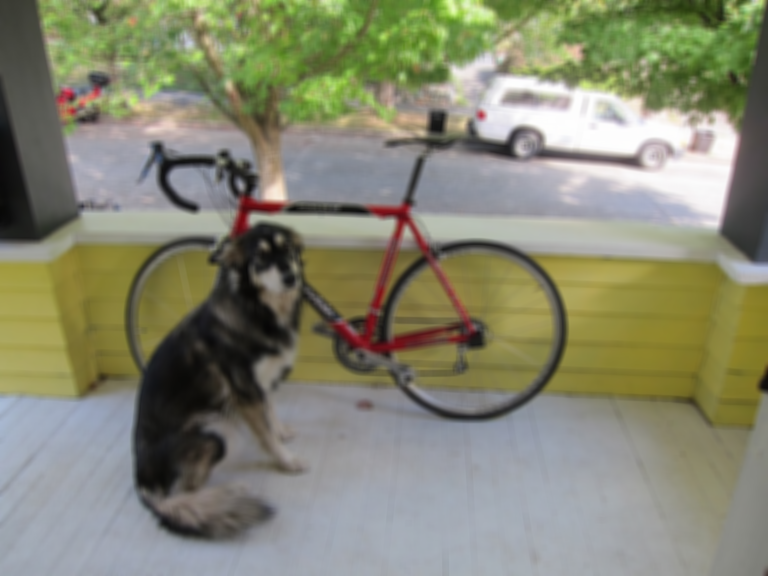

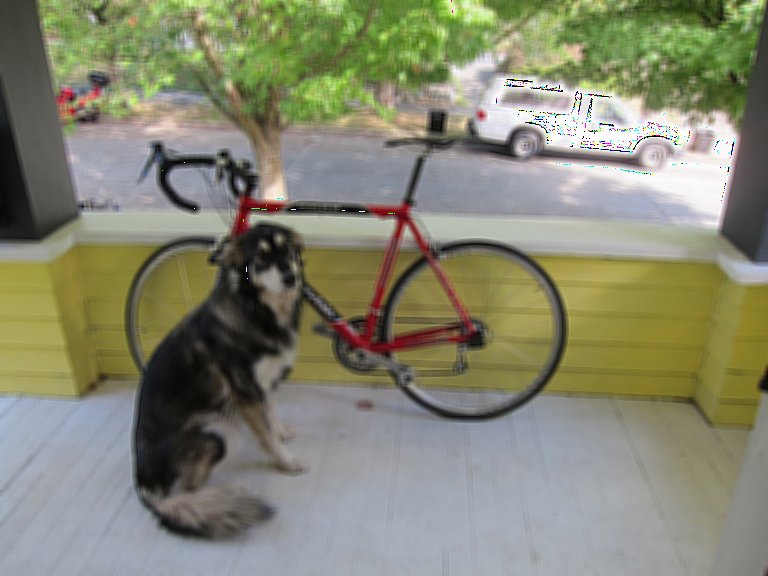

In [48]:
im = Image.open('../data/dog.jpg')
filter = box_filter(7,7)
im = imconv(im, filter, preserve=1)
filter = cool_filter('sharpen')
im_filt = imconv(im, filter, preserve=1)
display(im)
display(im_filt)


# Submission

Answer the questions, zip your entire folder and submit it on Canvas under Assignment 2.